In [1]:
# Preamble
import numpy as np
import glob
import matplotlib
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits import mplot3d
import pandas as pd
import os
import seissolxdmf
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from stl import mesh
from mpl_toolkits import mplot3d


In [2]:
def cohesion(depth):
    return 0.-1000*np.max([depth+2000., 0])
def sig_zz(rho, depth):
    return (rho - 1000.0)*9.81*min(-1500.0, depth)
# Filter according to a line (cross section)
max_dist_strip = 1.  # allowed distance far from cross-section line

def filter_by_line(x, y, x1, x2, buffer_dist):

    #x1 = (px1,py1)
    #x2 = (px2,py2)
    
    max_dist_strip = buffer_dist
    
    filter_id = []
    # Check distance to the cross section plane and filter
    for i in range(len(x)):
        lon_float = x[i]
        lat_float = y[i]
        # Calculate horizontal distance (km) to the cross-section vertical plane
        num = np.abs((x2[0]-x1[0])*(x1[1]-lat_float) - (x1[0]-lon_float)*(x2[1]-x1[1]))
        den = np.sqrt((x2[0]-x1[0])**2 + (x2[1]-x1[1])**2)
        dist = num / den
        dist = dist
        # save if distance to the cross-section is less than max_dist_strip
        if dist < max_dist_strip:
            filter_id.append(i)
    return filter_id

In [3]:
# Read SeisSol file
fm = 'output_offm2p5_gapm5p0n_testrec/offm2p5_gapm5p0-fault.xdmf'
fp = 'output_offm2p5_gapp5p0n_testrec/offm2p5_gapp5p0-fault.xdmf'
# initiate class
sx_m = seissolxdmf.seissolxdmf(fm)
sx_p = seissolxdmf.seissolxdmf(fp)

# Number of cells
nElements_m = sx_m.ReadNElements()
nElements_p = sx_p.ReadNElements()
# Read time step
dt_m = sx_m.ReadTimeStep()
dt_p = sx_p.ReadTimeStep()
# Read number of time steps
ndt_m = sx_m.ReadNdt()
ndt_p = sx_p.ReadNdt()
# load geometry array as a numpy array of shape ((nodes, 3))
geom_m = sx_m.ReadGeometry()
geom_p = sx_p.ReadGeometry()
# load connectivity array as a numpy array of shape ((nElements, 3 or 4))
# The connectivity array gives for each cell a list of vertex ids.
topo_m = sx_m.ReadConnect()
topo_p = sx_p.ReadConnect()


#get all the nodes from seissol file
xy_fm = []
xx_fm = []
yy_fm = []
for n in geom_m:
    xy_fm.append(n[0]/1000)
    xx_fm.append(n[1]/1000)
    yy_fm.append(n[2]/1000)
xy_fp = []
xx_fp = []
yy_fp = []
for n in geom_p:
    xy_fp.append(n[0]/1000)
    xx_fp.append(n[1]/1000)
    yy_fp.append(n[2]/1000)

xy_fm = np.asarray(xy_fm)
xx_fm = np.asarray(xx_fm)
yy_fm = np.asarray(yy_fm)
xy_fp = np.asarray(xy_fp)
xx_fp = np.asarray(xx_fp)
yy_fp = np.asarray(yy_fp)

tri_id_m5 = np.loadtxt('tri_id_num_m5.txt', dtype=int, delimiter=' ', usecols=(0), unpack=True)
tri_id_p5 = np.loadtxt('tri_id_num_p5.txt', dtype=int, delimiter=' ', usecols=(0), unpack=True)

m5_ids = np.where(tri_id_m5 == 0)[0]
p5_ids = np.where(tri_id_p5 == 0)[0]


# arrange triangles
tri1 = []
tri2 = []
tri3 = []
for n in topo_m:
    tri1.append(n[0])
    tri2.append(n[1])
    tri3.append(n[2])
tria = []
for i in range(len(tri1)):
    tria.append([tri1[i], tri2[i], tri3[i]])
triangles_all_m = np.asarray(tria)
triangles_m = triangles_all_m[m5_ids]

# arrange triangles
tri1 = []
tri2 = []
tri3 = []
for n in topo_p:
    tri1.append(n[0])
    tri2.append(n[1])
    tri3.append(n[2])
tria = []
for i in range(len(tri1)):
    tria.append([tri1[i], tri2[i], tri3[i]])
triangles_all_p = np.asarray(tria)
triangles_p = triangles_all_p[p5_ids]

print(len(triangles_m), 'm5p0')
print(len(xy_fm), 'nodes in total m5')
print(len(triangles_p), 'p5p0')
print(len(xy_fp), 'nodes in total p5')

996 m5p0
6012 nodes in total m5
980 p5p0
6000 nodes in total p5


In [16]:
# Using an existing stl file:
bathy_mesh = mesh.Mesh.from_file('b.stl')

xp, yp, zp = [], [], []
filter_line = True
filter_box = True


# Get the max min to filter topo
x_all, y_all, z_all = [], [], []
z_surf = []
x_surf = []
y_surf = []
for i in range(len(triangles_p)):
    trip = triangles_p[i]
    x_all.append(xy_fp[trip[0]])
    y_all.append(xx_fp[trip[0]])
    z_all.append(yy_fp[trip[0]])
    if z_all[-1] == 0:
        x_surf.append(x_all[-1])
        y_surf.append(y_all[-1])
        z_surf.append(z_all[-1])
    x_all.append(xy_fp[trip[1]])
    y_all.append(xx_fp[trip[1]])
    z_all.append(yy_fp[trip[1]])
    if z_all[-1] == 0:
        x_surf.append(x_all[-1])
        y_surf.append(y_all[-1])
        z_surf.append(z_all[-1])
    x_all.append(xy_fp[trip[2]])
    y_all.append(xx_fp[trip[2]])
    z_all.append(yy_fp[trip[2]])
    if z_all[-1] == 0:
        x_surf.append(x_all[-1])
        y_surf.append(y_all[-1])
        z_surf.append(z_all[-1])

# for a square topography
miny = np.min(y_all) - 4
maxy = np.max(y_all) + 0
maxx = np.max(x_all) + 0
minx = np.min(x_all) - 5

# for a line topography
miny_surf = np.min(np.asarray(y_surf))
maxy_surf = np.max(np.asarray(y_surf))
minx_surf = np.min(np.asarray(x_surf))
maxx_surf = np.max(np.asarray(x_surf))
x1 = [maxx_surf*1000, miny_surf*1000]
x2 = [minx_surf*1000, maxy_surf*1000]

if filter_box == True:

    # filter topo by square area
    zsmax = []
    zsmin = []
    v = []
    for vi in bathy_mesh.vectors:
        li_x, li_y, li_z = [], [], []
        for j in range(3):
            x = vi[j][0]
            y = vi[j][1]
            z = vi[j][2]
            if x > minx*1000 and x < maxx*1000:
                if y > miny*1000 and y < maxy*1000:
                    li_x.append(x)
                    li_y.append(y)
                    li_z.append(z)
                    if j == 2:
                        li_x.append(li_x[0])
                        li_y.append(li_y[0])
                        li_z.append(li_z[0])
        if len(li_x) == 4:
            v.append(vi)
            xp.append(li_x)
            yp.append(li_y)
            zp.append(li_z)
            zsmax.append(np.max(zp)/1000)
            zsmin.append(np.min(zp)/1000)    

filter_line = True
#xp, yp, zp = [], [], []

#if filter_line == True:
    #print('here', len(v))
    ## filter topo by cross section
    #buffer_dist = 5000 #m
    #zsmax = []
    #zsmin = []
    #for i in range(len(v)):
    #    vi = v[i] #bathy_mesh.vectors[i]
    #    x, y, z = [], [], []
    #    for j in range(3):
    #        x.append(vi[j][0])
    #        y.append(vi[j][1])
    #        z.append(vi[j][2])
    #    vec_id = filter_by_line(x,y,x1,x2,buffer_dist)
    #    if len(vec_id) == 3:
    #        li_x = [x[0], x[1], x[2], x[0]]
    #        li_y = [y[0], y[1], y[2], y[0]]
    #        li_z = [z[0], z[1], z[2], z[0]]
    #    if len(li_x) == 4:
    #        xp.append(li_x)
    #        yp.append(li_y)
    #        zp.append(li_z)
    #        zsmax.append(np.max(zp)/1000)
    #        zsmin.append(np.min(zp)/1000)    

#Maximum elevation limits
maxz = np.max(np.asarray(zsmax))
minz = np.min(np.asarray(zsmin))
print(maxz,minz)
xp = np.asarray(xp) / 1000
yp = np.asarray(yp) / 1000
zp = np.asarray(zp) / 1000

2.364 0.599


In [17]:
print(len(xp))
#print(xp, len(xp), maxz)
#print(z_all)

2716


-2.347288487032195 -0.35835599994636524 min , max
0.4712351788522427
0.5063451889606095
0.5063451889606095
0.5198815449845368
0.5198815449845368
0.5198815449845368
0.5249577226170832
0.5122673289626585
0.552876497888323
0.5249577226170832
0.5579526250939281
0.5579526250939281
0.5579526250939281
0.5258037354135272
0.5258037354135272
0.4923858013249896
0.4923858013249896
0.4644670260537498
0.4644670260537498
0.4826565280985308
0.4826565280985308
0.49534687132601407
0.540609135845591
0.5198815449845368
0.5541454918695182
0.5431472246618643
0.5562605995010402
0.5423011614384788
0.5423011614384788
0.5198815449845368
0.5325718882120201
0.5198815449845368
0.5122673289626585
0.5122673289626585
0.5021150745514484
0.5025380557361997
0.5025380557361997
0.5025380557361997
0.4966159157341507
0.4966159157341507
0.47165821046393536
0.47165821046393536
0.4428934223962516
0.44543146078558343
0.49703889691890196
0.49703889691890196
0.52241963380081
0.52241963380081
0.52241963380081
0.5198815449845368
0.

/tmp/ipykernel_23369/2489744716.py:110: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  s = ax3.pcolor(x,y,a, vmin=minv,vmax=maxv, cmap=cmap)


0.5482233518674693
0.5203045765962294
0.5203045765962294
0.48773265530413584
0.48773265530413584
0.4805414708939503
0.4805414708939503
0.4619289372374766
0.4619289372374766
0.4323180859464074
0.4323180859464074
0.42681892712910974
0.44670050519372
0.45896786723645205
0.48730962369244313
0.4906937253051603
0.5279187926181077
0.5122673289626585
0.5313028942308249
0.5287648054145516
0.5313028942308249
0.5439932374583082
0.5439932374583082
0.5579526250939281
0.5579526250939281
0.5579526250939281
0.5613367267066453
0.5490693646639132
0.5833333115488947
0.5613367267066453
0.6023688768170611
0.5833333115488947
0.6277495632720276
0.6023688768170611
0.6683587321976922
0.6434010269274768
0.7051607678989469
0.696277507468932
0.7051607678989469
0.7309644859656061
0.7089678506964153
0.7309644859656061
0.6696277261788873
0.7089678506964153
0.6501691797259698
0.6683587321976922
0.6408629381112037
0.6408629381112037
0.6408629381112037
0.6429779953157841
0.6078680356343588
0.6429779953157841
0.60786803

0.28637901276299593
0.2939932287848742
0.29060912717215703
0.2965312923876767
0.2939932287848742
0.29780033679581336
0.2965312923876767
0.3071066036240502
0.3071066036240502
0.3109137116349893
0.34010153131436577
0.34010153131436577
0.348138753734466
0.3295262200779923
0.348138753734466
0.3295262200779923
0.3295262200779923
0.3286802072815484
0.3405245377125877
0.3434856077136122
0.3747884845975692
0.3747884845975692
0.40270728508227976
0.40270728508227976
0.43781724476370515
0.43781724476370515
0.48434855369141866
0.48434855369141866
0.5253807038018344
0.5253807038018344
0.5253807038018344
0.5308798626191322
0.5469543074593326
0.5879864575697484
0.601522864020617
0.6239424804745592
0.6319796776811887
0.6501691797259698
0.6501691797259698
0.6704737894022728
0.6501691797259698
0.6704737894022728
0.6565144017666528
0.6565144017666528
0.6425550141310329
0.6425550141310329
0.6408629381112037
0.6408629381112037
0.6324027092928814
0.6324027092928814
0.6252115248826958
0.633671753701018
0.625

0.40862945029779946
0.42512690153622185
0.44204735917286625
0.4813874836903942
0.4813874836903942
0.5313028942308249
0.5397631230491471
0.5833333115488947
0.5926396035906022
0.6404399569264524
0.6404399569264524
0.6857022214460292
0.6857022214460292
0.7182740923111814
0.7182740923111814
0.732656511558494
0.732656511558494
0.732656511558494
0.7250422955366158
0.7296954415574696
0.6975465518770686
0.7064297618801421
0.6548223257468235
0.6628595733803945
0.6345177664974619
0.6345177664974619
0.6391709125183157
0.6391709125183157
0.6104060740236905
0.6391709125183157
0.5634517839112257
0.6104060740236905
0.5439932374583082
0.5634517839112257
0.5414551486420349
0.5439932374583082
0.5414551486420349
0.5414551486420349
0.5414551486420349
0.5414551486420349
0.5427241930501715
0.5427241930501715
0.5596446506868159
0.5427241930501715
0.571065999933104
0.5596446506868159
0.571065999933104
0.571065999933104
0.5697969555249675
0.565989872727499
0.5744501015458212
0.5697969555249675
0.57445010154582

0.40270728508227976
0.40270728508227976
0.3934010182540429
0.4031302914805017
0.3934010182540429
0.4314720731499635
0.4314720731499635
0.4771573692812331
0.4771573692812331
0.5427241930501715
0.5232656465972539
0.6129441628399638
0.5723350443412407
0.6865482342424732
0.6175973088608175
0.7381556703757918
0.6865482342424732
0.7390016831722357
0.7381556703757918
0.7525380896231043
0.7390016831722357
0.7567682040322654
0.7525380896231043
0.7567682040322654
0.7542301152159921
0.7542301152159921
0.7343485371513819
0.727580384352889
0.7110829079009958
0.6954314946724881
0.6954314946724881
0.6785109866089023
0.6785109866089023
0.6785109866089023
0.6556683385432674
0.6556683385432674
0.6357868109055986
0.6357868109055986
0.6353637792939059
0.6353637792939059
0.6319796776811887
0.6501691797259698
0.6319796776811887
0.6501691797259698
0.6501691797259698
0.6412859697228963
0.6412859697228963
0.5981387624079
0.6222504044547299
0.5748730827305725
0.5858714003651679
0.5693739239132748
0.574027069934

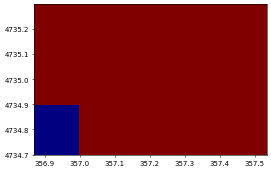

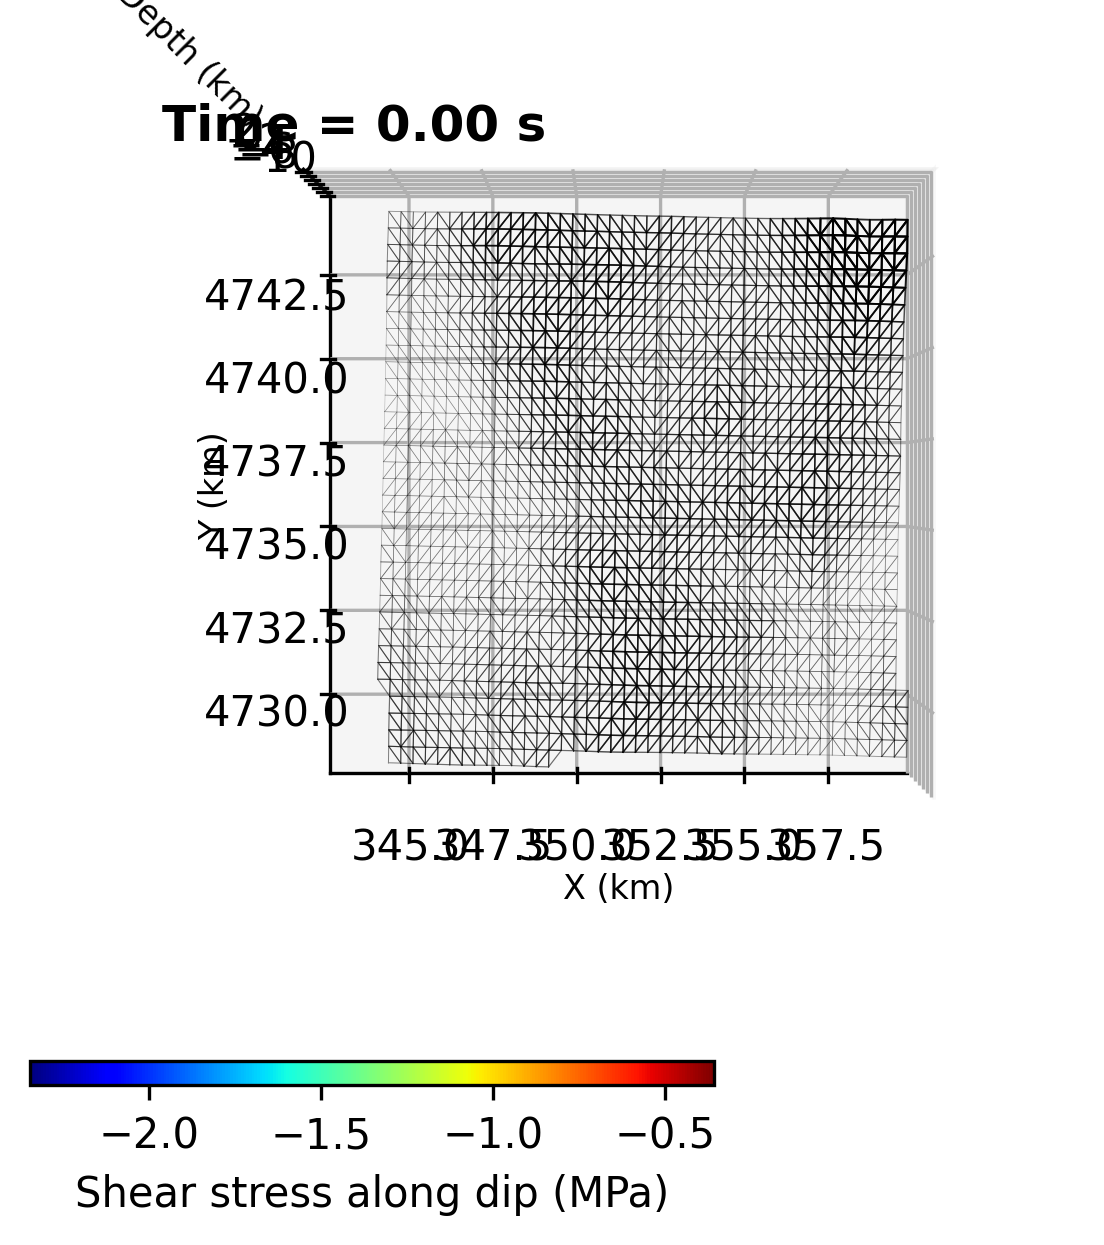

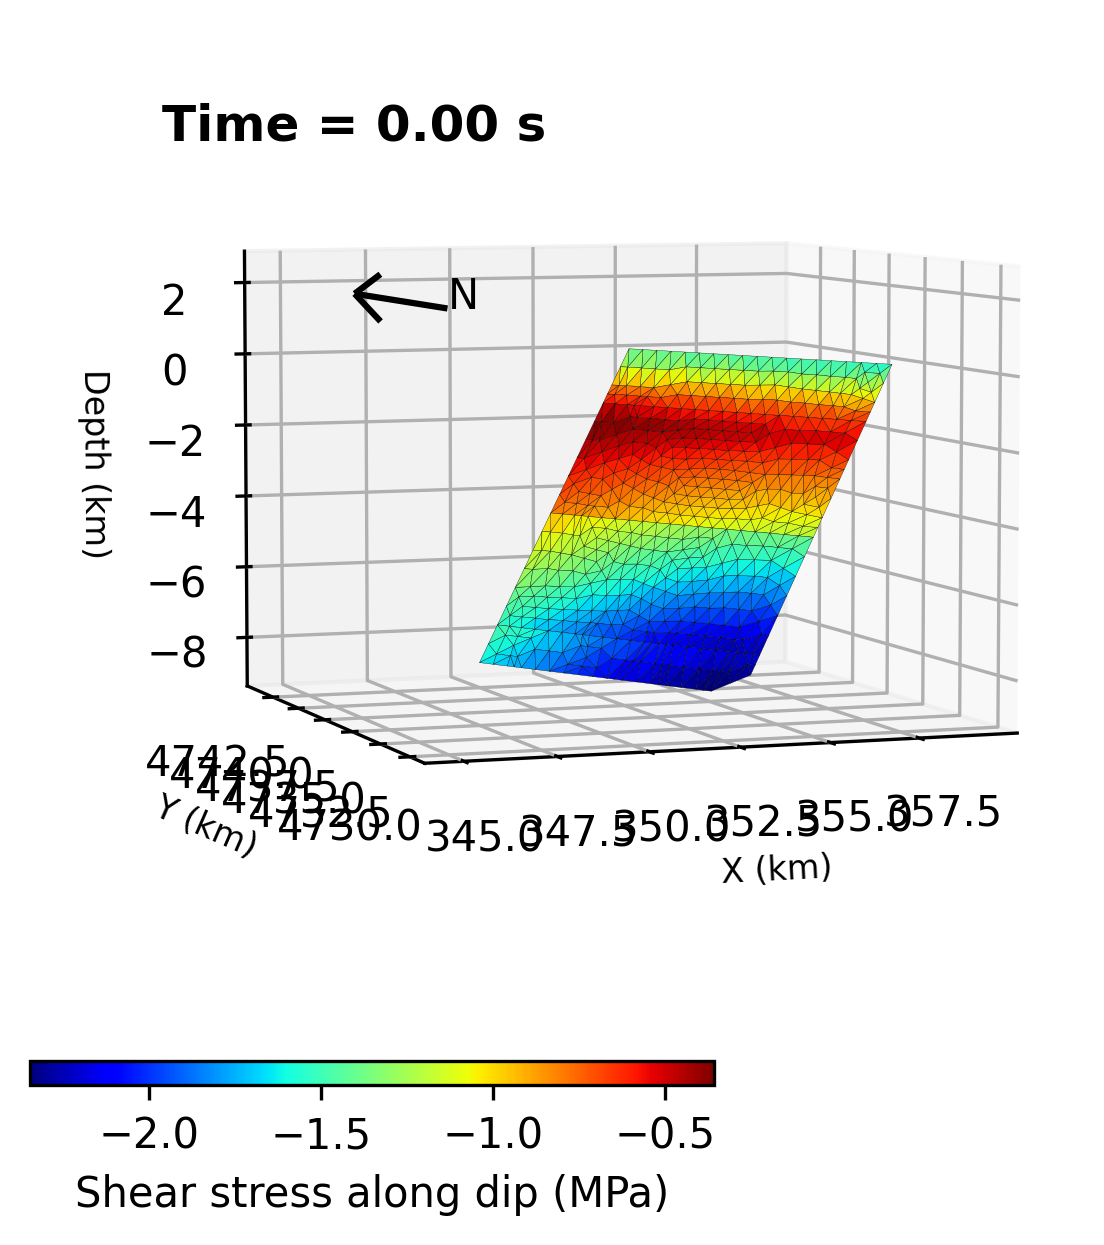

In [18]:
scale = 1000000
fontz = 8
# time sample to see
#T = np.linspace(0,88,89)
T = [0]
#T = np.linspace(0,80,81)
# angle of view to the faults
azim = [380]

# For the NORTH arrow in the Figure
xq = 345
yq = 4730
zq = 2
u = 0
v = 1
w = 0

zlim=[-10, 3]
ylim=[4730-2, 4742.5+2]
xlim=[345-2, 357.5+2]

sin_back = np.sin(80*np.pi/180)
cos_back = np.cos(80*np.pi/180)

counter = 0
for iii in range(len(T)):
    mu_s = 0.6   # To change with time?
    # DELTA PLOTS
    a = 0.2*(T[iii])#-1)
    b = "{:.2f}".format(a)
    titl = 'Time = ' + b +' s'
    # delta tau
    # Delta CFF
    Td0_m = sx_m.ReadData('Td0', int(T[iii]))
    Ts0_m = sx_m.ReadData('Ts0', int(T[iii]))
    Pn0_m = sx_m.ReadData('Pn0', int(T[iii]))
    Td_m = sx_m.ReadData('T_d', int(T[iii]))
    Ts_m = sx_m.ReadData('T_s', int(T[iii]))
    Pn_m = sx_m.ReadData('P_n', int(T[iii]))
    
    Td0_p = sx_p.ReadData('Td0', int(T[iii]))
    Ts0_p = sx_p.ReadData('Ts0', int(T[iii]))
    Pn0_p = sx_p.ReadData('Pn0', int(T[iii]))
    Td_p = sx_p.ReadData('T_d', int(T[iii]))
    Ts_p = sx_p.ReadData('T_s', int(T[iii]))
    Pn_p = sx_p.ReadData('P_n', int(T[iii]))
    

    # Minus fault position
    Td0_m = Td0_m / scale
    Ts0_m = Ts0_m / scale
    Pn0_m = Pn0_m / scale * -1
    Td0_m = Td0_m[m5_ids]
    Ts0_m = Ts0_m[m5_ids]
    Pn0_m = Pn0_m[m5_ids]
    Td_m = Td_m / scale
    Ts_m = Ts_m / scale
    Pn_m = Pn_m / scale * -1
    Td_m = Td_m[m5_ids]
    Ts_m = Ts_m[m5_ids]
    Pn_m = Pn_m[m5_ids]
    SRd_m = sx_m.ReadData('SRd', int(T[iii]))
    SRs_m = sx_m.ReadData('SRs', int(T[iii]))
    Sld_m = sx_m.ReadData('Sld', int(T[iii]))
    Sls_m = sx_m.ReadData('Sld', int(T[iii]))
    
    # Plus fault position
    Td0_p = Td0_p / scale
    Ts0_p = Ts0_p / scale
    Pn0_p = Pn0_p / scale * -1
    Td0_p = Td0_p[p5_ids]
    Ts0_p = Ts0_p[p5_ids]
    Pn0_p = Pn0_p[p5_ids]
    Td_p = Td_p / scale
    Ts_p = Ts_p / scale
    Pn_p = Pn_p / scale * -1
    Td_p = Td_p[p5_ids]
    Ts_p = Ts_p[p5_ids]
    Pn_p = Pn_p[p5_ids]
    SRd_p = sx_p.ReadData('SRd', int(T[iii]))
    SRs_p = sx_p.ReadData('SRs', int(T[iii]))
    Sld_p = sx_p.ReadData('Sld', int(T[iii]))
    Sls_p = sx_p.ReadData('Sld', int(T[iii]))

    # DCFF
    D_cff_m = Td0_m - mu_s * (Pn0_m)
    D_cff_p = Td0_p - mu_s * (Pn0_p)
    
    #if counter == 0:
    #    CFF_0_m = D_cff_m
    #    CFF_0_p = D_cff_p
    
    #D_cff_m = D_cff_m - CFF_0_m
    #D_cff_p = D_cff_p - CFF_0_p

    
    minv = np.min(D_cff_p) 
    maxv = np.max(D_cff_p) 
    print(minv,maxv, 'min , max') 

    # To create the correct colobar
    fig3 = plt.figure(dpi=50)
    cmap = plt.cm.get_cmap('jet')
    ax3 = fig3.add_subplot(1, 1, 1)
    a = np.zeros((5, 5), dtype=float)
    a[4][4] = maxv #/ scale
    a[0][0] = minv #/ scale
    x = xy_fm[0:5]
    y = xx_fm[0:5]
    s = ax3.pcolor(x,y,a, vmin=minv,vmax=maxv, cmap=cmap)

    
    #cmap_m = cm.jet(np.array(Td0_m) / maxv )
    #cmap_p = cm.jet(np.array(Td0_p) / maxv )
    #cmap_m = cm.jet(np.array(D_cff_m)  )
    #cmap_p = cm.jet(np.array(D_cff_p)  )
    figname1 = 'Figp_'+str(int(T[iii])).zfill(3)+'.pdf'
    figname2 = 'Figm_'+str(int(T[iii])).zfill(3)+'.pdf'
    fig2 = plt.figure(dpi=300)
    fig2.suptitle(titl, x=0.3, y=0.92, fontweight='bold')
    ax2 = fig2.add_subplot(2, 2, 1, projection='3d')
    ax2.set_position([0.05,0.2, 0.78, 0.78])
    #ax2.scatter(xp, yp, zp, s=0.1, c='black')
    #m = vpl.mesh_plot(mesh)
    for i in range(len(triangles_p)):
        trip = triangles_p[i]
        x = [xy_fp[trip[0]], xy_fp[trip[1]], xy_fp[trip[2]]]
        y = [xx_fp[trip[0]], xx_fp[trip[1]], xx_fp[trip[2]]]
        z = [yy_fp[trip[0]], yy_fp[trip[1]], yy_fp[trip[2]]]
        #try:
        length = np.abs(maxv - minv)
        length_i = (D_cff_p[i] - minv)
        length_normalized = length_i / length
        cmap_p = cm.jet(length_normalized)
    #    surf = ax2.plot_trisurf(x, y, z, triangles=trip,
    #                linewidth = 0.08, edgecolor='black',
    #                color=cmap_p)

    #ax2.quiver(xq, yq, zq, u, v, w, length=3, normalize=True, color='black')
    #ax2.text(xq, yq, zq, 'N')
    ax2.set_fc('None')
    ax2.set_facecolor((0,0,0,0))
    ax2.axis('equal')
    ax2.set_xlabel('X (km)', fontsize=fontz)
    ax2.set_ylabel('Y (km)', fontsize=fontz)
    ax2.set_zlabel('Depth (km)', fontsize=fontz)
    #surf.set_clim( minv, maxv )
    cbaxes = fig2.add_axes([0.12, 0.1, 0.38, 0.02]) 
    cb = fig2.colorbar(s, ax=ax3, cax=cbaxes, orientation='horizontal')
    cb.set_label('Shear stress along dip (MPa)')
    ax2.set_zlim(zlim)
    ax2.set_ylim(ylim)
    ax2.set_xlim(xlim)
    minz = 0
    for p in range(len(xp)):
        alph = ( np.max(zp[p]) - minz ) / (maxz - minz)
        lwa = alph*0.5 + 0.01
        print(alph)
        if alph > 1:
            alph = 1
        ax2.plot(xp[p], yp[p], zp[p], linestyle='solid', lw=lwa, color='black', alpha=alph)
    ax2.view_init(elev=90, azim=-90, roll=0)

    fig4 = plt.figure(dpi=300)
    fig4.suptitle(titl, x=0.3, y=0.92, fontweight='bold')
    ax2 = fig4.add_subplot(2, 2, 1, projection='3d')
    ax2.set_position([0.05,0.2, 0.78, 0.78])
    for i in range(len(triangles_m)):
        trip = triangles_m[i]
        x = [xy_fm[trip[0]], xy_fm[trip[1]], xy_fm[trip[2]]]
        y = [xx_fm[trip[0]], xx_fm[trip[1]], xx_fm[trip[2]]]
        z = [yy_fm[trip[0]], yy_fm[trip[1]], yy_fm[trip[2]]]
        #try:
        length = np.abs(maxv - minv)
        length_i = (D_cff_m[i] - minv)
        length_normalized = length_i / length
        cmap_m = cm.jet(length_normalized)
        surf = ax2.plot_trisurf(x, y, z, triangles=trip,
                    linewidth = 0.08, edgecolor='black',
                    color=cmap_m)
        
    ax2.quiver(xq, yq, zq, u, v, w, length=8, normalize=True, color='black')
    ax2.text(xq, yq, zq, 'N')
    ax2.set_fc('None')
    ax2.set_facecolor((0,0,0,0))
    ax2.axis('equal')
    ax2.set_xlabel('X (km)', fontsize=fontz)
    ax2.set_ylabel('Y (km)', fontsize=fontz)
    ax2.set_zlabel('Depth (km)', fontsize=fontz)
    #edges.cmap = plt.cmap.coolwarm
    surf.set_clim( minv, maxv )
    #cbar = plt.colorbar(surf, cmap=cmap)
    #sm = plt.cm.ScalarMappable(cmap=cmap)
    cbaxes = fig4.add_axes([0.12, 0.1, 0.38, 0.02]) 
    cb = fig4.colorbar(s, ax=ax3, cax=cbaxes, orientation='horizontal')
    cb.set_label('Shear stress along dip (MPa)')
    #ax2.set_xticklabels(x, fontsize=8)
    #ax2.set_yticklabels(['47.30',' ','47.35',' ','47.40'])
    ax2.view_init(elev=5, azim=-110, roll=0)

    fig4.savefig(figname2)    
    fig2.savefig(figname1)

In [9]:
import vtkplotlib as vpl
from stl.mesh import Mesh

fig2 = plt.figure(dpi=300)
fig2.suptitle(titl, x=0.3, y=0.92, fontweight='bold')


# path = "if you have an STL file then put it's path here."
# Otherwise vtkplotlib comes with a small STL file for demos/testing.
path = 'b.stl'#vpl.data.get_rabbit_stl()

# Read the STL using numpy-stl
mesh = Mesh.from_file(path)

# Plot the mesh
ax2 = vpl.mesh_plot(mesh)

# Show the figure
vpl.show()

[[ 2.4385180e+05  4.6374945e+06 -1.2200000e+02]
 [ 2.4419775e+05  4.6374820e+06 -1.2200000e+02]
 [ 2.4421436e+05  4.6379445e+06 -1.2000000e+02]] [ 2.4385180e+05  4.6374945e+06 -1.2200000e+02  2.4419775e+05
  4.6374820e+06 -1.2200000e+02  2.4421436e+05  4.6379445e+06
 -1.2000000e+02]


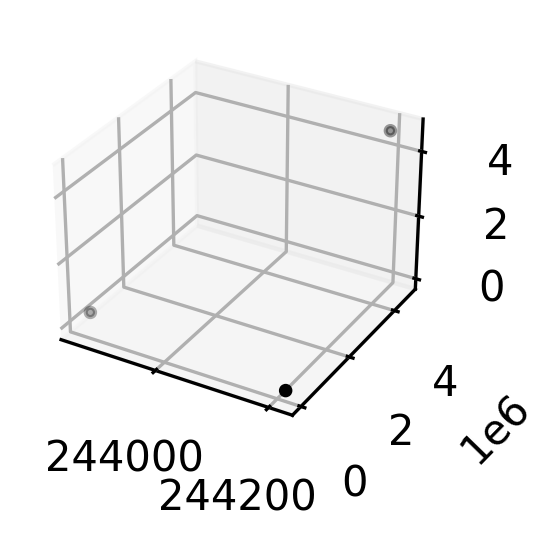

In [21]:
fig4 = plt.figure(dpi=300)
#fig4.suptitle(titl, x=0.3, y=0.92, fontweight='bold')
ax2 = fig4.add_subplot(2, 2, 1, projection='3d')
xp = [bathy_mesh.points[0][0], bathy_mesh.points[0][3], bathy_mesh.points[0][6]]
yp = [bathy_mesh.points[0][3], bathy_mesh.points[0][4], bathy_mesh.points[0][5]]
zp = [bathy_mesh.points[0][6], bathy_mesh.points[0][7], bathy_mesh.points[0][8]]
c = ['black', 'black', 'black']



In [6]:
print(triangles_m)

[[   0    1    2]
 [   3    4    5]
 [   6    7    8]
 ...
 [5991 5992 5993]
 [5994 5995 5996]
 [5997 5998 5999]]


In [10]:
# coordinates vettore fault   fv
xx_fv, yy_fv, zz_fv = np.loadtxt('ver_1.txt', delimiter=' ', usecols=(0, 1, 2), unpack=True)
xx_fv = xx_fv / 100000
yy_fv = yy_fv / 100000
zz_fv = zz_fv / 1000

# Coordinates laga fault MINUS
xx_flm, yy_flm, zz_flm = np.loadtxt('ver_2.txt', delimiter=' ', usecols=(0, 1, 2), unpack=True)
xx_flm = xx_flm / 100000
yy_flm = yy_flm / 100000
zz_flm = zz_flm / 1000

# Coordinates laga fault PLUS
xx_flp, yy_flp, zz_flp = np.loadtxt('ver_3.txt', delimiter=' ', usecols=(0, 1, 2), unpack=True)
xx_flp = xx_flp / 100000
yy_flp = yy_flp / 100000
zz_flp = zz_flp / 1000

# Depth to plot fault trace on mapview
dep_min = -3.1
dep_max = -2.9


# Getting nodes at a given depth
xx_f1, yy_f1, zz_f1 = [], [], []
xx_f2, yy_f2, zz_f2 = [], [], []
xx_f3, yy_f3, zz_f3 = [], [], []
for i in range(len(xx_flm)):
    if zz_flm[i] > dep_min and zz_flm[i] < dep_max:
        xx_f1.append(xx_flm[i])
        yy_f1.append(yy_flm[i])
        zz_f1.append(zz_flm[i])
for i in range(len(xx_fv)):
    if zz_fv[i] > dep_min and zz_fv[i] < dep_max:
        xx_f2.append(xx_fv[i])
        yy_f2.append(yy_fv[i])
        zz_f2.append(zz_fv[i])
for i in range(len(xx_flp)):
    if zz_flp[i] > dep_min and zz_flp[i] < dep_max:
        xx_f3.append(xx_flp[i])
        yy_f3.append(yy_flp[i])
        zz_f3.append(zz_flp[i])


In [8]:
fontz = 10

# Load the virtual receiver coordinates (horizontal)
xx = np.loadtxt('xx_coord.dat', usecols=(0), unpack=True)
yy = np.loadtxt('yy_coord.dat', usecols=(0), unpack=True)

xx = xx / 100000
yy = yy / 100000


x_p, y_p = np.loadtxt('prof_vet.dat', usecols=(0, 1), unpack=True)
x_p = x_p / 100000.
y_p = y_p / 100000.

x_p2, y_p2 = np.loadtxt('prof_vet_2.dat', usecols=(0, 1), unpack=True)
x_p2 = x_p2 / 100000.
y_p2 = y_p2 / 100000.
z_p2 = np.linspace(0,-14.500,30)


vet_trace = np.loadtxt('vettore_trace_3k_depth.dat', delimiter=' ', usecols=(0,1), unpack=True)
lag_trace = np.loadtxt('llaga_trace_overlap.dat', delimiter=' ', usecols=(0,1), unpack=True)
lag_trace_p5 = np.loadtxt('llaga_p5_3k.dat', delimiter=' ', usecols=(0,1), unpack=True)
lag_trace_m5 = np.loadtxt('llaga_m5_3k.dat', delimiter=' ', usecols=(0,1), unpack=True)

vet_trace = vet_trace / 100000
lag_trace = lag_trace / 100000
lag_trace_m5 = lag_trace_m5 / 100000
lag_trace_p5 = lag_trace_p5 / 100000

# Strike vector
stk_v = [-0.43051,   0.90259,   0.00000];
stk_v = np.array(stk_v)
a = [349584,  4.74132e+6,  -8500];
b = [354640,  4.74373e+6,  -500];
a = np.array(a)
b = np.array(b)
# Dip vector
dip_v = (a-b)/np.linalg.norm(a-b);

# Normal vector to the fault
n_v = np.cross(stk_v,dip_v);
n_v = n_v/np.linalg.norm(n_v);
n = n_v

# Static coefficient
mu_s = 0.6

# Rotation matrix
matrix = np.array([dip_v,stk_v,n_v])

# List of files
snaps_list = glob.glob('output_h_plus/lines_00*.dat')
snaps_list.sort()


# Read a given receiver and check the CFF time series at that receiver location
rec_id_fault = 19*4 + 15
rec_id_fault_2 = 19*6 + 7
path = 'output_offm2p5_gapm5p0n/offm2p5_gapm5p0-faultreceiver-'
file_name = path + str(rec_id_fault).zfill(5) + '-00000.dat'
with open(file_name) as fin:
    lines = fin.readlines()
x_rec_f = float(lines[2].split("       ")[1])/100000
y_rec_f = float(lines[3].split("       ")[1])/100000
z_rec_f = float(lines[4].split("      ")[1])/1000
#print("rec fault coords: ",x_rec_f,y_rec_f,z_rec_f)

path = 'output_offm2p5_gapm5p0n/offm2p5_gapm5p0-faultreceiver-'
file_name = path + str(rec_id_fault_2).zfill(5) + '-00000.dat'
with open(file_name) as fin:
    lines = fin.readlines()
x_rec_f_2 = float(lines[2].split("       ")[1])/100000
y_rec_f_2 = float(lines[3].split("       ")[1])/100000
z_rec_f_2 = float(lines[4].split("      ")[1])/1000
#print("rec fault coords: ",x_rec_f_2,y_rec_f_2,z_rec_f)



# Horizontal dimension
nx = 40;
ny = 55;

# Dimension vertical profile
nstk = 31;
nz = 30;

stk = np.linspace(0,500*(nstk-1),31)
zz = np.linspace(-500*(nz-1) + 500,500,30)

stk = stk / 1000;
zz = zz / 1000;

dt_stamp = 0.1   # sampling of output files
delay_samp = 6   # lines of header

# FOR THE RECEIVER PLOT

# Read a given receiver and check the CFF time series at that receiver location
rec_id = 31*6 + 18
path = 'output_v_plus_vet/offm2p5_gapp5p0-receiver-'
file_name = path + str(rec_id).zfill(5) + '-00000.dat'
with open(file_name) as fin:
    lines_2 = fin.readlines()
path = 'output_v_plus_vet_f/offm2p5_gapm5p0-receiver-'
file_name = path + str(rec_id).zfill(5) + '-00000.dat'
with open(file_name) as fin:
    lines = fin.readlines()
x_rec = float(lines[2].split("       ")[1])/100000
y_rec = float(lines[3].split("       ")[1])/100000
z_rec = float(lines[4].split("       ")[1])/1000
#print("rec coords: ",x_rec,y_rec,z_rec)
nt = len(lines)-5
time_rec = np.zeros((nt))
sxx_rec = np.zeros((nt))
syy_rec = np.zeros((nt))
szz_rec = np.zeros((nt))
sxy_rec = np.zeros((nt))
syz_rec = np.zeros((nt))
sxz_rec = np.zeros((nt))
u_rec = np.zeros((nt))
v_rec = np.zeros((nt))
w_rec = np.zeros((nt))
t1_rec = np.zeros((nt))
t2_rec = np.zeros((nt))
t3_rec = np.zeros((nt))
s1_rec = np.zeros((nt))
s2_rec = np.zeros((nt))
s3_rec = np.zeros((nt))
delta_tau_rec = np.zeros((nt))
delta_sig_rec = np.zeros((nt))
delta_cff_rec = np.zeros((nt))

time_rec_2 = np.zeros((nt))
sxx_rec_2 = np.zeros((nt))
syy_rec_2 = np.zeros((nt))
szz_rec_2 = np.zeros((nt))
sxy_rec_2 = np.zeros((nt))
syz_rec_2 = np.zeros((nt))
sxz_rec_2 = np.zeros((nt))
u_rec_2 = np.zeros((nt))
v_rec_2 = np.zeros((nt))
w_rec_2 = np.zeros((nt))
t1_rec_2 = np.zeros((nt))
t2_rec_2 = np.zeros((nt))
t3_rec_2 = np.zeros((nt))
s1_rec_2 = np.zeros((nt))
s2_rec_2 = np.zeros((nt))
s3_rec_2 = np.zeros((nt))
delta_tau_rec_2 = np.zeros((nt))
delta_sig_rec_2 = np.zeros((nt))
delta_cff_rec_2 = np.zeros((nt))

max_c = []
min_c = []
for i in range(nt):
    time_rec[i] = lines[i+5].split("  ")[1]
    sxx_rec[i] = lines[i+5].split("  ")[2]
    syy_rec[i] = lines[i+5].split("  ")[3]
    szz_rec[i] = lines[i+5].split("  ")[4]
    sxy_rec[i] = lines[i+5].split("  ")[5]
    syz_rec[i] = lines[i+5].split("  ")[6]
    sxz_rec[i] = lines[i+5].split("  ")[7]
    u_rec[i] = lines[i+5].split("  ")[8]
    v_rec[i] = lines[i+5].split("  ")[9]
    w_rec[i] = lines[i+5].split("  ")[10]
    sig_rec = np.array([[sxx_rec[i], sxy_rec[i], sxz_rec[i]], [sxy_rec[i], syy_rec[i], syz_rec[i]], [sxz_rec[i], syz_rec[i], szz_rec[i]]])
    t = sig_rec.dot(n)
    # Shear and normal stress
    tau = t - (np.dot(n,t))*n
    sigma = np.dot(n,t)*n
    # Rotated vectors
    taup = matrix.dot(tau)
    sigmap = matrix.dot(sigma)
    t1_rec[i] = taup[0]
    t2_rec[i] = taup[1]
    t3_rec[i] = taup[2]
    s1_rec[i] = sigmap[0]
    s2_rec[i] = sigmap[1]
    s3_rec[i] = sigmap[2]
    delta_tau_rec[i] = t1_rec[i]            
    #%multiply delta_sigma by -1 to change the seissol convention (negative = compression)
    delta_sig_rec[i] = -1.0*sigmap[2]
    delta_cff_rec[i] = delta_tau_rec[i] + mu_s*delta_sig_rec[i]

    time_rec_2[i] = lines_2[i+5].split("  ")[1]
    sxx_rec_2[i] = lines_2[i+5].split("  ")[2]
    syy_rec_2[i] = lines_2[i+5].split("  ")[3]
    szz_rec_2[i] = lines_2[i+5].split("  ")[4]
    sxy_rec_2[i] = lines_2[i+5].split("  ")[5]
    syz_rec_2[i] = lines_2[i+5].split("  ")[6]
    sxz_rec_2[i] = lines_2[i+5].split("  ")[7]
    u_rec_2[i] = lines_2[i+5].split("  ")[8]
    v_rec_2[i] = lines_2[i+5].split("  ")[9]
    w_rec_2[i] = lines_2[i+5].split("  ")[10]
    sig_rec = np.array([[sxx_rec_2[i], sxy_rec_2[i], sxz_rec_2[i]], [sxy_rec_2[i], syy_rec_2[i], syz_rec_2[i]], [sxz_rec_2[i], syz_rec_2[i], szz_rec_2[i]]])
    t = sig_rec.dot(n)
    # Shear and normal stress
    tau = t - (np.dot(n,t))*n
    sigma = np.dot(n,t)*n
    # Rotated vectors
    taup = matrix.dot(tau)
    sigmap = matrix.dot(sigma)
    t1_rec_2[i] = taup[0]
    t2_rec_2[i] = taup[1]
    t3_rec_2[i] = taup[2]
    s1_rec_2[i] = sigmap[0]
    s2_rec_2[i] = sigmap[1]
    s3_rec_2[i] = sigmap[2]
    delta_tau_rec_2[i] = t1_rec_2[i]            
    #%multiply delta_sigma by -1 to change the seissol convention (negative = compression)
    delta_sig_rec_2[i] = -1.0*sigmap[2]
    delta_cff_rec_2[i] = delta_tau_rec_2[i] + mu_s*delta_sig_rec_2[i]

max_cff_rec = np.abs(np.max(delta_cff_rec_2)/1000000)
min_cff_rec = np.abs(np.min(delta_cff_rec_2)/1000000)
abs_cff_rec = np.max([max_cff_rec, min_cff_rec])
max_cff_rec = abs_cff_rec
min_cff_rec = -1.*abs_cff_rec

mm = []
mp = []

counter = 0
T_rec_m = []
P_rec_m = []
T_rec_p = []
P_rec_p = []
T_rec_m_2 = []
P_rec_m_2 = []
T_rec_p_2 = []
P_rec_p_2 = []
SRd_m_rec = []
SRd_p_rec = []
SRd_m_rec_2 = []
SRd_p_rec_2 = []

nxv = 31
nyv = 30

for it in snaps_list:
    time_stamp = ( float(it.split("/")[1][-8:-4]) - delay_samp ) * dt_stamp
    time_lim =  int(it.split("/")[1][-8:-4]) - delay_samp
    #print(it)
    # Cut recording for the receiver plot
    ttime_rec = time_rec[0:time_lim]
    ddelta_cff_rec = delta_cff_rec[0:time_lim]
    ttime_rec_2 = time_rec_2[0:time_lim]
    ddelta_cff_rec_2 = delta_cff_rec_2[0:time_lim]
    time_stamp_title = "Time: " + format(0.2*counter, '.1f') + ' s'
    it_compare = 'output_h_plus_f/' + it.split("/")[1]
    it_v1_compare = 'output_v_plus_vet/' + it.split("/")[1]
    it_v2_compare = 'output_v_plus_vet_f/' + it.split("/")[1]
    out1 = 'horizontal_delta_' + str(counter).zfill(5) + '.png'

    # TRIANGLES DATA
    ##########################################
    col_Ts = 3
    col_Td = 4
    col_Pn = 5
    col_Ts0 = 9
    col_Td0 = 10
    col_Pn0 = 11
    fileout = 'fault_' + str(counter).zfill(5) + '.png'
    T_d_m = []
    P_n_m = []
    T_d_p = []
    T_s_m = []
    T_s_p = []
    P_n_p = []
    SRd_p = []
    SRd_m = []
    T_d0_m = []
    T_s0_m = []
    T_d0_p = []
    T_s0_p = []
    P_n0_m = []
    P_n0_p = []
    for i in range(len(cx_fm)):
        # T_d column 4
        # P_n column 5
        T_d_m.append(data_m[i][counter][col_Td])
        T_s_m.append(data_m[i][counter][col_Ts])
        P_n_m.append(data_m[i][counter][col_Pn])
        T_d0_m.append(data_m[i][0][col_Td0])
        T_s0_m.append(data_m[i][0][col_Ts0])
        P_n0_m.append(data_m[i][0][col_Pn0])
        SRd_m.append(data_m[i][counter][13])
    for i in range(len(cx_fp)):
        T_d_p.append(data_p[i][counter][col_Td])
        T_s_p.append(data_p[i][counter][col_Ts])
        P_n_p.append(data_p[i][counter][col_Pn])
        T_d0_p.append(data_m[i][0][col_Td0])
        T_s0_p.append(data_m[i][0][col_Ts0])
        P_n0_p.append(data_m[i][0][col_Pn0])
        SRd_p.append(data_p[i][counter][13])  # 2 SRd, 13 Sld
    # Receiver on fault #1
    T_rec_m.append(data_m[rec_id_fault][counter][col_Td])
    P_rec_m.append(data_m[rec_id_fault][counter][col_Pn])    
    T_rec_p.append(data_p[rec_id_fault][counter][col_Td])
    P_rec_p.append(data_p[rec_id_fault][counter][col_Pn])    
    T_rec_m_arr = np.asarray(T_rec_m)
    P_rec_m_arr = np.asarray(P_rec_m)
    T_rec_p_arr = np.asarray(T_rec_p)
    P_rec_p_arr = np.asarray(P_rec_p)
    tt = np.linspace(0,(counter*0.2),counter+1)
    D_cff_rec_m = T_rec_m_arr - mu_s * P_rec_m_arr
    D_cff_rec_p = T_rec_p_arr - mu_s * P_rec_p_arr    
    # Receiver on fault #2
    T_rec_m_2.append(data_m[rec_id_fault_2][counter][col_Td])
    P_rec_m_2.append(data_m[rec_id_fault_2][counter][col_Pn])    
    T_rec_p_2.append(data_p[rec_id_fault_2][counter][col_Td])
    P_rec_p_2.append(data_p[rec_id_fault_2][counter][col_Pn])    
    T_rec_m_2_arr = np.asarray(T_rec_m_2)
    P_rec_m_2_arr = np.asarray(P_rec_m_2)
    T_rec_p_2_arr = np.asarray(T_rec_p_2)
    P_rec_p_2_arr = np.asarray(P_rec_p_2)
    D_cff_rec_m_2 = T_rec_m_2_arr - mu_s * P_rec_m_2_arr
    D_cff_rec_p_2 = T_rec_p_2_arr - mu_s * P_rec_p_2_arr    
    SRd_m_rec.append(data_m[rec_id_fault][counter][2])
    SRd_p_rec.append(data_p[rec_id_fault][counter][2])
    SRd_m_rec_2.append(data_m[rec_id_fault_2][counter][2])
    SRd_p_rec_2.append(data_p[rec_id_fault_2][counter][2])

    SRd_p_rec_2_arr = np.asarray(SRd_p_rec_2)
    SRd_m_rec_2_arr = np.asarray(SRd_m_rec_2)
    SRd_p_rec_arr = np.asarray(SRd_p_rec)
    SRd_m_rec_arr = np.asarray(SRd_m_rec)
    
    
    T_d_m = np.asarray(T_d_m)
    T_s_m = np.asarray(T_s_m)
    P_n_m = np.asarray(P_n_m) * -1. # seissol convention test
    T_d0_m = np.asarray(T_d0_m)
    T_s0_m = np.asarray(T_s0_m)
    P_n0_m = np.asarray(P_n0_m) * -1. # seissol convention test
    T_d_p = np.asarray(T_d_p)
    T_s_p = np.asarray(T_s_p)
    P_n_p = np.asarray(P_n_p) * -1.
    T_d0_p = np.asarray(T_d0_p)
    T_s0_p = np.asarray(T_s0_p)
    P_n0_p = np.asarray(P_n0_p) * -1.
    T_ds_m = np.sqrt((T_d0_m+T_d_m)**2. + (T_s0_m+T_s_m)**2.)
    T_ds_p = np.sqrt((T_d0_p+T_d_p)**2. + (T_s0_p+T_s_p)**2.)
    
    D_cff_m = T_ds_m - mu_s * (P_n_m + P_n0_m)
    D_cff_p = T_ds_p - mu_s * (P_n_p + P_n0_p)
    D_cff_m = D_cff_m / scale_factor
    D_cff_p = D_cff_p / scale_factor
    
    if counter == 0:
        CFF_0_m = D_cff_m
        CFF_0_p = D_cff_p
    
    D_cff_p = D_cff_p - CFF_0_p
    D_cff_m = D_cff_m - CFF_0_m
    
    SRd_m = np.asarray(SRd_m)
    SRd_p = np.asarray(SRd_p)
    #max_c_m.append(max(D_cff_m))
    #min_c_m.append(min(D_cff_m))
    #max_c_p.append(max(D_cff_p))
    #min_c_p.append(min(D_cff_p))
    zfaces_m_sr = SRd_m[triangles_m].mean(axis = 1) #D_cff_m[triangles].mean(axis = 1)
    zfaces_p_sr = SRd_p[triangles_p].mean(axis = 1) #D_cff_p[triangles].mean(axis = 1)
    zfaces_m_cff = D_cff_m[triangles_m].mean(axis = 1) #D_cff_m[triangles].mean(axis = 1)
    zfaces_p_cff = D_cff_p[triangles_p].mean(axis = 1) #D_cff_p[triangles].mean(axis = 1)
    ########################################

    counter = counter + 1

    #Load the data horizontal
    time_hm, sxx_hm, syy_hm, szz_hm, sxy_hm, syz_hm, sxz_hm, u_hm, v_hm, w_hm = np.loadtxt(it_compare, delimiter=' ', usecols=(0,1,2,3,4,5,6,7,8,9), unpack=True)

    #Load the data horizontal
    time_hp, sxx_hp, syy_hp, szz_hp, sxy_hp, syz_hp, sxz_hp, u_hp, v_hp, w_hp = np.loadtxt(it, delimiter=' ', usecols=(0,1,2,3,4,5,6,7,8,9), unpack=True)

    #Load the data horizontal
    time_vp, sxx_vp, syy_vp, szz_vp, sxy_vp, syz_vp, sxz_vp, u_vp, v_vp, w_vp = np.loadtxt(it_v1_compare, delimiter=' ', usecols=(0,1,2,3,4,5,6,7,8,9), unpack=True)

    #Load the data horizontal
    time_vm, sxx_vm, syy_vm, szz_vm, sxy_vm, syz_vm, sxz_vm, u_vm, v_vm, w_vm = np.loadtxt(it_v2_compare, delimiter=' ', usecols=(0,1,2,3,4,5,6,7,8,9), unpack=True)

    
    # Save space for variables
    t1_hm = np.zeros((ny,nx))
    t2_hm = np.zeros((ny,nx))
    t3_hm = np.zeros((ny,nx))
    s1_hm = np.zeros((ny,nx))
    s2_hm = np.zeros((ny,nx))
    s3_hm = np.zeros((ny,nx))
    delta_tau_hm = np.zeros((ny,nx))
    delta_sig_hm = np.zeros((ny,nx))
    delta_cff_hm = np.zeros((ny,nx))
    uhm = np.zeros((ny,nx))
    vhm = np.zeros((ny,nx))
    whm = np.zeros((ny,nx))

    # Save space for variables
    t1_hp = np.zeros((ny,nx))
    t2_hp = np.zeros((ny,nx))
    t3_hp = np.zeros((ny,nx))
    s1_hp = np.zeros((ny,nx))
    s2_hp = np.zeros((ny,nx))
    s3_hp = np.zeros((ny,nx))
    delta_tau_hp = np.zeros((ny,nx))
    delta_sig_hp = np.zeros((ny,nx))
    delta_cff_hp = np.zeros((ny,nx))
    uhp = np.zeros((ny,nx))
    vhp = np.zeros((ny,nx))
    whp = np.zeros((ny,nx))

    
    # Save space for variables
    t1_vm = np.zeros((nxv,nyv))
    t2_vm = np.zeros((nxv,nyv))
    t3_vm = np.zeros((nxv,nyv))
    s1_vm = np.zeros((nxv,nyv))
    s2_vm = np.zeros((nxv,nyv))
    s3_vm = np.zeros((nxv,nyv))
    delta_tau_vm = np.zeros((nxv,nyv))
    delta_sig_vm = np.zeros((nxv,nyv))
    delta_cff_vm = np.zeros((nxv,nyv))
    uvm = np.zeros((nxv,nyv))
    vvm = np.zeros((nxv,nyv))
    # Save space for variables
    t1_vp = np.zeros((nyv,nxv))
    t2_vp = np.zeros((nyv,nxv))
    t3_vp = np.zeros((nyv,nxv))
    s1_vp = np.zeros((nyv,nxv))
    s2_vp = np.zeros((nyv,nxv))
    s3_vp = np.zeros((nyv,nxv))
    delta_tau_vp = np.zeros((nyv,nxv))
    delta_sig_vp = np.zeros((nyv,nxv))
    delta_cff_vp = np.zeros((nyv,nxv))
    uvp = np.zeros((nyv,nxv))
    vvp = np.zeros((nyv,nxv))
    wvp = np.zeros((nyv,nxv))

    
    #invert order
    ndata_hm = len(time_hm);
    k = ndata_hm-1;
    n = n_v;
    ii = nx;
    for i in range(nx):
        jj = ny;
        for j in range(ny):
            sig_hm = np.array([[sxx_hm[k], sxy_hm[k], sxz_hm[k]], [sxy_hm[k], syy_hm[k], syz_hm[k]], [sxz_hm[k], syz_hm[k], szz_hm[k]]])
            t = sig_hm.dot(n)
            # Shear and normal stress
            tau = t - (np.dot(n,t))*n
            sigma = np.dot(n,t)*n
            # Rotated vectors
            taup = matrix.dot(tau)
            sigmap = matrix.dot(sigma)
            t1_hm[j][i] = taup[0]
            t2_hm[j][i] = taup[1]
            t3_hm[j][i] = taup[2]
            s1_hm[j][i] = sigmap[0]
            s2_hm[j][i] = sigmap[1]
            s3_hm[j][i] = sigmap[2]
            delta_tau_hm[j][i] = t1_hm[j][i]            
            #%multiply delta_sigma by -1 to change the seissol convention (negative = compression)
            delta_sig_hm[j][i] = -1.0*sigmap[2]
            delta_cff_hm[j][i] = delta_tau_hm[j][i] + mu_s*delta_sig_hm[j][i]
            uhm[j][i] = u_hm[k]
            vhm[j][i] = v_hm[k]
            whm[j][i] = w_hm[k]
            jj = jj-1
            k=k-1
    delta_cff_hm = delta_cff_hm / scale_factor
    mm.append(np.max(whm))
    
    #invert order
    ndata_hp = len(time_hp);
    k = ndata_hp-1;
    n = n_v;
    ii = nx;
    for i in range(nx):
        jj = ny;
        for j in range(ny):
            sig_hp = np.array([[sxx_hp[k], sxy_hp[k], sxz_hp[k]], [sxy_hp[k], syy_hp[k], syz_hp[k]], [sxz_hp[k], syz_hp[k], szz_hp[k]]])
            t = sig_hp.dot(n)
            # Shear and normal stress
            tau = t - (np.dot(n,t))*n
            sigma = np.dot(n,t)*n
            # Rotated vectors
            taup = matrix.dot(tau)
            sigmap = matrix.dot(sigma)
            t1_hp[j][i] = taup[0]   # shear stress to the fault
            t2_hp[j][i] = taup[1]
            t3_hp[j][i] = taup[2]
            #print(taup[0],taup[1],taup[2])
            s1_hp[j][i] = sigmap[0]
            s2_hp[j][i] = sigmap[1]
            s3_hp[j][i] = sigmap[2]
            delta_tau_hp[j][i] = t1_hp[j][i]            
            #%multiply delta_sigma by -1 to change the seissol convention (negative = compression)
            delta_sig_hp[j][i] = -1.0*sigmap[2]  # normal stress if i am right
            delta_cff_hp[j][i] = delta_tau_hp[j][i] + mu_s*delta_sig_hp[j][i]
            uhp[j][i] = u_hp[k]
            vhp[j][i] = v_hp[k]
            whp[j][i] = w_hp[k]
            jj = jj-1
            k=k-1
    delta_cff_hp = delta_cff_hp / scale_factor
    mp.append(np.max(whp))

    
    wvm = np.zeros((30,31))    
    wvp = np.zeros((30,31))    
    #invert order
    ndata_vm = len(time_vm);
    k = 929;
    n = n_v;
    for i in range(30):
        nnn = 29 - i
        for j in range(31):
            nnnn = 30 - j
            wvm[i][j] = v_vm[k]
            wvp[i][j] = v_vp[k]
            k=k-1

    
    
    # Figures    hf, ha = plt.subplots(3,2)

    ninter = 5
  # for contour plots
    c_max_d =  8000000 / scale_factor
    c_min_d = -8000000 / scale_factor
    
    c_min_s = -5000000
    c_max_s =  5000000
    
    c_min_w = -1
    c_max_w =  1
    
    
    inter_d = np.linspace(c_min_d,c_max_d,ninter)
    inter_s = np.linspace(c_min_s,c_max_s,ninter)
    inter_w = np.linspace(c_min_w,c_max_w,ninter)

    cmap = matplotlib.cm.get_cmap('gray')
    
    # DELTA PLOTS
    fig1, axs1 = plt.subplots(2, 5, dpi=500, facecolor='white')
    fig1.suptitle(time_stamp_title, x=0.9, y=0.99, fontweight='bold')
    # delta tau
    # Delta CFF
    ax1 = axs1[0, 0]
#    c = ax1.pcolor(xx, yy, delta_cff_hp, cmap=cmap, vmin=c_min_d, vmax=c_max_d)
    c = ax1.pcolor(xx, yy, whp, cmap=cmap, vmin=c_min_w, vmax=c_max_w)
#    d = ax1.plot(vet_trace[0][:], vet_trace[1][:], linestyle='solid', color='magenta', linewidth=2)
#    e = ax1.plot(lag_trace_p5[0][:], lag_trace_p5[1][:], linestyle='solid', color='magenta', linewidth=2)
    #dd = ax1.scatter(xx_f2, yy_f2, s=0.8, marker='o', c='beige', linewidths=0)
    d = ax1.plot(xx_f2, yy_f2, linestyle='solid', color='magenta', linewidth=1)
    e = ax1.plot(xx_f3, yy_f3, linestyle='solid', color='magenta', linewidth=1)
    
    #, marker='o', color='pink', edgecolor='pink', facecolor='pink') # linestyle='solid', color='black', linewidth=0.5)
    #ee = ax1.scatter(xx_flm, yy_flm, 0.01)#, marker='o', color='pink', edgecolor='pink', facecolor='pink')
    #ax1.scatter(x_rec, y_rec, 10, marker='o', color='black', facecolors='none')
    #f = ax3.contour(xx, yy, delta_cff_h, inter_d, colors='white', linewidth=0.4)
    ax1.set_position([0.03,0.6, 0.3, 0.34])
    ax1.set_title(r'Map view $V_z$', fontsize=10)
    ax1.axis('equal')
    ax1.set_aspect('equal', 'box')
    ax1.set_ylabel('Latitude', fontsize=fontz)
    ax1.set_xlabel('Longitude', fontsize=fontz)

    #f = ax1.plot(x_p, y_p, linestyle='solid', color='black', linewidth=1.5)
    #g = ax1.plot(x_p2, y_p2, linestyle='dashed', color='cyan', linewidth=2)

    
    
    ax2 = axs1[1, 0]
#    c = ax2.pcolor(xx, yy, delta_cff_hm, cmap=cmap, vmin=c_min_d, vmax=c_max_d)
    c = ax2.pcolor(xx, yy, whm, cmap=cmap, vmin=c_min_w, vmax=c_max_w)
    #d = ax2.plot(vet_trace[0][:], vet_trace[1][:], linestyle='solid', color='magenta', linewidth=2)
    #e = ax2.plot(lag_trace_m5[0][:], lag_trace_m5[1][:], linestyle='solid', color='magenta', linewidth=2)
    d = ax2.plot(xx_f2, yy_f2, linestyle='solid', color='magenta', linewidth=1)
    e = ax2.plot(xx_f1, yy_f1, linestyle='solid', color='magenta', linewidth=1)
    #ax2.scatter(x_rec, y_rec, 10, marker='o', color='black', facecolors='none')
    #f = ax3.contour(xx, yy, delta_cff_h, inter_d, colors='white', linewidth=0.4)
    ax2.set_position([0.235,0.6, 0.3, 0.34])
    ax2.set_title(r'Map view $V_z$', fontsize=10)
    ax2.set_yticklabels([])
    ax2.axis('equal')
    ax2.set_aspect('equal', 'box')
    ax2.set_xlabel('Longitude', fontsize=fontz)
    #g = ax2.plot(x_p2, y_p2, linestyle='dashed', color='cyan', linewidth=2)

    #ax3.set_position([0.35,0.1, 0.35, 0.35])
    cbaxes = fig1.add_axes([0.85, 0.22, 0.02, 0.72]) 
    cb = fig1.colorbar(c, ax=ax1, cax=cbaxes)
    cb.set_label('Particle velocity (m/s)')

    
    c_max_d = c_max_w #250000 / scale_factor
    c_min_d = c_min_w #-250000 / scale_factor
    levels = np.linspace(c_min_d, c_max_d, 6)

    ax3 = axs1[0, 2]
    ax3.set_aspect('equal')
    ax3.set_title('Mt. Vettore', fontsize=10)
    ax3.set_position([0.29,0.22, 0.2, 0.2])
    tpc_m = ax3.tripcolor(xx_fm, yy_fm, triangles_m,
                    facecolors = zfaces_m_cff,
                    cmap = cmap,
                    edgecolors = 'black',
                    linewidth = 0.1,
                    #shading = 'flat',
                    vmax = 10,
                    vmin = -10)
    #ax3.scatter(yy_f2[1], zz_f2[1], s=0.8, marker='o', c='black', linewidths=0)
    #tc = ax4.tricontour(xx_m, yy_m, zfaces_m, levels=levels, linewidths=0.2, colors=colors_l)
    #tcl = ax4.clabel(tc, colors='w', fontsize=3, inline=1, fmt = '%1.0f')
    #ax3.scatter(y_rec_f_2*100, z_rec_f_2, 9, edgecolor='white', color='red')
    ax3.set_yticklabels([])
    ax3.set_xlabel(r'Latitude ($^o$)', fontsize=fontz)
    ax3.set_xticklabels(['47.35','47.35','47.40'])
    
    #print(xx_f,yy_f)
    
    ax4 = axs1[1, 2]
    ax4.set_title('Mt. Vettore', fontsize=10)
    ax4.set_aspect('equal')
    ax4.set_position([0.07,0.22, 0.2, 0.2])
    tpc_p = ax4.tripcolor(xx_fp, yy_fp, triangles_p,
                    facecolors = zfaces_p_cff,
                    cmap = cmap,
                    edgecolors = 'black',
                    linewidth = 0.1,
                    #shading = 'flat',
                    vmax = 10,
                    vmin = -10)
    #ax4.scatter(yy_f2, zz_f2, s=2.8, marker='o', c='black', linewidths=0)
    #tc = ax5.tricontour(xx_m, yy_m, zfaces_p, levels=levels, linewidths=0.2, colors=colors_l)
    #tcl = ax5.clabel(tc, colors='w', fontsize=5, inline=1, fmt = '%1.0f')
    #ax4.scatter(y_rec_f*100, z_rec_f, 9, edgecolor='white', color='blue')
    #ax4.scatter(y_rec_f_2*100, z_rec_f_2, 9, edgecolor='white', color='red')
    ax4.set_ylabel('Depth (km)', fontsize=fontz)
    ax4.set_xlabel(r'Latitude ($^o$)', fontsize=fontz)
    ax4.set_xticklabels(['47.35','47.35','47.40'])

    xxx = 3.564127460000
    yyy = -3
    yyy_a = 0
    xxx_a = xxx + ((np.abs(yyy_a-yyy)/110)/np.tan(55*np.pi/180))
    yyy_b = -8.5
    xxx_b = xxx - ((np.abs(yyy_b-yyy)/110)/np.tan(55*np.pi/180))
    xxx = [xxx_b, xxx, xxx_a]
    yyy = [yyy_b, yyy, yyy_a]
    
    ax5 = axs1[1, 1]
    #ax5.set_aspect('equal')
    ax5.set_title('Mt. Vettore', fontsize=10)
    ax5.set_position([0.59, 0.69, 0.25, 0.25])
    c = ax5.pcolor( x_p2, z_p2, wvm, cmap=cmap, vmin=c_min_w, vmax=c_max_w)
    d = ax5.plot( xxx, yyy, color='magenta', linestyle='solid', lw=1)

    #tc = ax4.tricontour(xx_m, yy_m, zfaces_m, levels=levels, linewidths=0.2, colors=colors_l)
    #tcl = ax4.clabel(tc, colors='w', fontsize=3, inline=1, fmt = '%1.0f')    
    ax5.set_xlabel(r'Cross-section (lon)', fontsize=fontz)
    ax5.set_ylabel(r'Depth (km)', fontsize=fontz)

    
    ax6 = axs1[0, 1]
    ax6.set_title('Mt. Vettore', fontsize=10)
    ax6.set_position([0.59, 0.22, 0.25, 0.25])
    c = ax6.pcolor(x_p2, z_p2, wvp, cmap=cmap, vmin=c_min_w, vmax=c_max_w)
    d = ax6.plot( xxx, yyy, color='magenta', linestyle='solid', lw=1)

    #tc = ax4.tricontour(xx_m, yy_m, zfaces_m, levels=levels, linewidths=0.2, colors=colors_l)
    #tcl = ax4.clabel(tc, colors='w', fontsize=3, inline=1, fmt = '%1.0f')    
    ax6.set_xlabel(r'Cross-section (lon)', fontsize=fontz)
    ax6.set_ylabel(r'Depth (km)', fontsize=fontz)

      
#    axs1[0, 1].axis('off')
#    axs1[0, 2].axis('off')
    axs1[0, 3].axis('off')
    axs1[0, 4].axis('off')
#    axs1[1, 1].axis('off')
#    axs1[1, 2].axis('off')
    axs1[1, 3].axis('off')
    axs1[1, 4].axis('off')
    

    ax1.tick_params(axis='both', which='major', labelsize=fontz)
    ax2.tick_params(axis='both', which='major', labelsize=fontz)
    ax3.tick_params(axis='both', which='major', labelsize=fontz)
    ax4.tick_params(axis='both', which='major', labelsize=fontz)
    ax5.tick_params(axis='both', which='major', labelsize=fontz)
    ax6.tick_params(axis='both', which='major', labelsize=fontz)
    cb.ax.tick_params(labelsize=fontz)
    
    
    ax1.text(3.66, 47.44, 'FW', horizontalalignment='center',
        verticalalignment='center')
    ax2.text(3.66, 47.44, 'HW', horizontalalignment='center',
        verticalalignment='center')
    ax4.text(4743, -8.8, 'FW', horizontalalignment='center')
    ax3.text(4743, -8.8, 'HW', horizontalalignment='center')
    ax5.text(3.625, -14, 'HW', horizontalalignment='center')
    ax6.text(3.625, -14, 'FW', horizontalalignment='center')

    fig1.savefig(out1)




NameError: name 'cx_fm' is not defined

In [35]:
zfaces_m_cff

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [22]:
T_d_m**2.

array([0., 0., 0., ..., 0., 0., 0.])

In [162]:
yy_f

array([-2.97224262, -2.56387409, -2.9836857 , ..., -0.99629441,
       -0.5       , -1.        ])

In [18]:
    maxy =  1.0
    miny = -0.1 
    ax3 = axs1[0, 1]
    hp = ax3.plot(tt, SRd_p_rec_arr, lw=1, color='tab:blue')
    hm = ax3.plot(tt, SRd_m_rec_arr, lw=1, color='tab:blue', linestyle='dashed')
    #just for the legend
    #hp = ax3.plot(tt, 50e6+D_cff_rec_p, lw=2, color='black', label='Vet_on_footwall')
    #hm = ax3.plot(tt, 50e6+D_cff_rec_m, lw=2, color='black', linestyle='dashed', label='Vet_on_hangingwall')
    #end of thing for the legend
    ax3.scatter(y_rec_f*100, z_rec_f, 20, edgecolor='black', color='blue', label='Shallow')
    ax3.set_position([0.09,0.27, 0.22, 0.15])
    ax3.set_xlim((0, np.max(time_rec)))
    #ax3.set_ylim((np.min(delta_cff_rec_2)*1.3, np.max(delta_cff_rec_2)*1.3))
    ax3.set_ylim((miny, maxy))
    #ax3.set_xlabel('Time (s)')
    ax3.set_ylabel(r'SRd (m)')
    ax3.grid()
    ax3.set_yticks([0, 0.5, 1])
    ax3.set_xticklabels([])
    leg = ax3.legend(ncol=2, loc=[0.12, 1.01], prop={'size': 8})
    leg.get_frame().set_edgecolor('none')
    leg.get_frame().set_facecolor('none')

    ax6 = axs1[1, 1]
    hp = ax6.plot(tt, SRd_p_rec_2_arr, lw=1, color='tab:red')
    hm = ax6.plot(tt, SRd_m_rec_2_arr, lw=1, color='tab:red', linestyle='dashed')
    ax6.scatter(y_rec_f_2*100, z_rec_f_2, 20, edgecolor='black', color='red', label='Deep')
    ax6.set_position([0.32,0.27, 0.22, 0.15])
    ax6.set_xlim((0, np.max(time_rec)))
    #ax3.set_ylim((np.min(delta_cff_rec_2)*1.3, np.max(delta_cff_rec_2)*1.3))
    ax6.set_ylim((miny, maxy))
    ax6.set_yticks([0, 0.5, 1])
    ax6.set_yticklabels([])
    ax6.set_xticklabels([])
    #ax6.set_xlabel('Time (s)')
    #ax6.set_xlabelticks([])
    #ax6.set_ylabel(r'SRd (m/s)')
    ax6.grid()
    leg = ax6.legend(ncol=2, loc=[0.12, 1.01], prop={'size': 8})
    leg.get_frame().set_edgecolor('none')
    leg.get_frame().set_facecolor('none')

    maxy =  1.3
    miny = -4.0 
    ax9 = axs1[0, 4]
    hp = ax9.plot(tt, D_cff_rec_p / 1e06, lw=1, color='tab:blue')
    hm = ax9.plot(tt, D_cff_rec_m / 1e06, lw=1, color='tab:blue', linestyle='dashed')
    #just for the legend
    #hp = ax3.plot(tt, 50e6+D_cff_rec_p, lw=2, color='black', label='Vet_on_footwall')
    #hm = ax3.plot(tt, 50e6+D_cff_rec_m, lw=2, color='black', linestyle='dashed', label='Vet_on_hangingwall')
    #end of thing for the legend
    ax9.scatter(y_rec_f*100, z_rec_f, 20, edgecolor='black', color='blue', label='Shallow')
    ax9.set_position([0.09,0.1, 0.22, 0.15])
    ax9.set_xlim((0, np.max(time_rec)))
    #ax3.set_ylim((np.min(delta_cff_rec_2)*1.3, np.max(delta_cff_rec_2)*1.3))
    ax9.set_ylim((miny, maxy))
    ax9.set_xlabel('Time (s)')
    ax9.set_ylabel(r'$\Delta$CFF (MPa)')
    ax9.grid()
    #leg = ax9.legend(ncol=2, loc=[0.12, 1.01], prop={'size': 8})
    #leg.get_frame().set_edgecolor('none')
    #leg.get_frame().set_facecolor('none')

    ax10 = axs1[1, 4]
    hp = ax10.plot(tt, D_cff_rec_p_2 / 1e06, lw=1, color='tab:red')
    hm = ax10.plot(tt, D_cff_rec_m_2 / 1e06, lw=1, color='tab:red', linestyle='dashed')
    ax10.scatter(y_rec_f_2*100, z_rec_f_2, 20, edgecolor='black', color='red', label='Deep')
    ax10.set_position([0.32,0.1, 0.22, 0.15])
    ax10.set_xlim((0, np.max(time_rec)))
    #ax10.set_ylim((np.min(delta_cff_rec_2)*1.3, np.max(delta_cff_rec_2)*1.3))
    ax10.set_ylim((miny, maxy))
    ax10.set_xlabel('Time (s)')
    ax10.set_yticklabels([])
    #ax10.set_ylabel(r'$\Delta$CFF (MPa)')
    ax10.grid()
    #leg = ax10.legend(ncol=2, loc=[0.12, 1.01], prop={'size': 8})
    #leg.get_frame().set_edgecolor('none')
    #leg.get_frame().set_facecolor('none')

    
      
    c_max_d =  0.05 # 250000 / scale_factor
    c_min_d =  0. #-250000 / scale_factor
    levels = np.linspace(c_min_d, c_max_d, 6)

    
    cbaxes = fig1.add_axes([0.58, 0.57, 0.18, 0.03]) 
    cb = fig1.colorbar(tpc_p, ax=ax5, cax=cbaxes, orientation='horizontal')
    cb.set_label(r'Slip dip (m)')
    cb.ax.tick_params(rotation=0)    
    cb.set_ticks([0, 0.02, 0.04])

    c_max_d =   2500000 / scale_factor
    c_min_d =  -2500000 / scale_factor
    levels = np.linspace(c_min_d, c_max_d, 6)
    
    ax7 = axs1[0, 3]
    #ax7.set_title(r'$\Delta$CFF')
    ax7.set_aspect('equal')
    ax7.set_position([0.8,0.22, 0.2, 0.2])
    tpc_m = ax7.tripcolor(xx_f, yy_f, triangles,
                    facecolors = zfaces_m_cff,
                    cmap = cmap,
                    edgecolors ='k',
                    #shading = 'flat',
                    vmax = c_max_d,
                    vmin = c_min_d)
    #tc = ax4.tricontour(xx_m, yy_m, zfaces_m, levels=levels, linewidths=0.2, colors=colors_l)
    #tcl = ax4.clabel(tc, colors='w', fontsize=3, inline=1, fmt = '%1.0f')
    ax7.scatter(y_rec_f*100, z_rec_f, 9, edgecolor='white', color='blue')
    ax7.scatter(y_rec_f_2*100, z_rec_f_2, 9, edgecolor='white', color='red')
    ax7.set_yticklabels([])
    #ax7.set_ylabel('Depth (km)')

    cbaxes = fig1.add_axes([0.8, 0.11, 0.18, 0.03]) 
    cb = fig1.colorbar(tpc_m, ax=ax4, cax=cbaxes, orientation='horizontal')
    cb.set_label(r'$\Delta$CFF (MPa)')
    cb.ax.tick_params(rotation=0)    
    cb.set_ticks([-2.5, 0, 2.5])
    
    c_max_d =   2500000 / scale_factor
    c_min_d =  -2500000 / scale_factor
    levels = np.linspace(c_min_d, c_max_d, 6)

    ax8 = axs1[1, 3]
    ax8.set_title(r'$\Delta$CFF')
    ax8.set_aspect('equal')
    ax8.set_position([0.8,0.68, 0.2, 0.2])
    #ax5.set_xticklabels([])
    tpc_p = ax8.tripcolor(xx_f, yy_f, triangles,
                    facecolors = zfaces_p_cff,
                    cmap = cmap,
                    edgecolors ='k',
                    #shading = 'flat',
                    vmax = c_max_d,
                    vmin = c_min_d)
    #tc = ax5.tricontour(xx_m, yy_m, zfaces_p, levels=levels, linewidths=0.2, colors=colors_l)
    #tcl = ax5.clabel(tc, colors='w', fontsize=5, inline=1, fmt = '%1.0f')
    ax8.scatter(y_rec_f*100, z_rec_f, 9, edgecolor='white', color='blue')
    ax8.scatter(y_rec_f_2*100, z_rec_f_2, 9, edgecolor='white', color='red')
    ax8.set_yticklabels([])
    #ax8.set_ylabel('Depth (km)')
    
    cbaxes = fig1.add_axes([0.8, 0.57, 0.18, 0.03]) 
    cb = fig1.colorbar(tpc_p, ax=ax5, cax=cbaxes, orientation='horizontal')
    cb.set_label(r'$\Delta$CFF (MPa)')
    cb.ax.tick_params(rotation=0)    
    cb.set_ticks([-2.5, 0, 2.5])
    
    #cntr2 = ax4.tricontourf(xx_m, yy_m, zfaces, levels=14, cmap="RdBu_r")
    ax1.tick_params(axis='both', which='major', labelsize=9)
    ax2.tick_params(axis='both', which='major', labelsize=9)
    ax3.tick_params(axis='both', which='major', labelsize=9)
    ax4.tick_params(axis='both', which='major', labelsize=9)
    ax5.tick_params(axis='both', which='major', labelsize=9)
    ax6.tick_params(axis='both', which='major', labelsize=9)
    ax7.tick_params(axis='both', which='major', labelsize=9)
    ax8.tick_params(axis='both', which='major', labelsize=9)
    ax9.tick_params(axis='both', which='major', labelsize=9)
    ax10.tick_params(axis='both', which='major', labelsize=9)

    ax3.set_xticks([0, 5, 10, 15])
    ax6.set_xticks([0, 5, 10, 15])
    ax9.set_xticks([0, 5, 10, 15])
    ax10.set_xticks([0, 5, 10, 15])
    ax9.set_yticks([-4, -2, 0, 1])
    ax10.set_yticks([-4, -2, 0, 1])
    
    dx = vet_trace[0][1] - vet_trace[0][0]
    dy = vet_trace[1][1] - vet_trace[1][0]
    
    ax1.arrow(vet_trace[0][0]+0.005, vet_trace[1][0]+0.04, dx*0.5, dy*0.5, color='green', head_length=0.01, head_width=0.01)
    ax2.arrow(vet_trace[0][0]+0.005, vet_trace[1][0]+0.04, dx*0.5, dy*0.5, color='green', head_length=0.01, head_width=0.01)
    ax8.annotate('', xy=(0.25, -0.3), xycoords='axes fraction', xytext=(0.75, -0.3), 
            arrowprops=dict(arrowstyle="->", color='green'))
    ax7.annotate('', xy=(0.25, -0.3), xycoords='axes fraction', xytext=(0.75, -0.3), 
            arrowprops=dict(arrowstyle="->", color='green'))
    ax5.annotate('', xy=(0.25, -0.3), xycoords='axes fraction', xytext=(0.75, -0.3), 
            arrowprops=dict(arrowstyle="->", color='green'))
    ax4.annotate('', xy=(0.25, -0.3), xycoords='axes fraction', xytext=(0.75, -0.3), 
            arrowprops=dict(arrowstyle="->", color='green'))

    ax4.set_xlim(ax4.get_xlim()[::-1])
    ax5.set_xlim(ax5.get_xlim()[::-1])
    ax7.set_xlim(ax7.get_xlim()[::-1])
    ax8.set_xlim(ax8.get_xlim()[::-1])



(4744.451591385, 4731.870420915)

In [152]:
print(zz_f1)

[-3.024569504662555, -3.024569504662555, -3.014689871310062, -3.024569504662555, -3.014689871310062, -3.014689871310062, -3.07206550417794, -3.021685954737481, -3.021685954737481, -3.021685954737481, -2.9713064052970206, -2.9713064052970206, -3.07206550417794, -2.9305386138675096, -2.9509225095822647, -2.9509225095822647, -2.9509225095822647, -2.9713064052970206, -3.0100864411716364, -3.017851210777274, -3.017851210777274, -3.0100864411716364, -3.0100864411716364, -3.017851210777274, -3.014689871310062, -3.014689871310062, -3.014689871310062, -3.024569504662555, -3.024569504662555, -3.024569504662555, -3.0169979227825974, -3.017851210777274, -3.017851210777274, -3.017851210777274, -3.0169979227825974, -3.0100864411716364, -2.949956511315673, -2.949956511315673, -3.0100864411716364, -3.0100864411716364, -2.949956511315673, -3.0, -2.9713064052970206, -3.07206550417794, -3.021685954737481, -3.021685954737481, -3.021685954737481, -2.9713064052970206, -3.07206550417794, -2.9305386138675096,